In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import pprint
from copy import deepcopy
from multiprocessing.pool import Pool

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

In [2]:
@functools.lru_cache(maxsize=None)
def distance(n1, n2):
    return math.sqrt((n1.cx - n2.cx)**2+(n1.cy - n2.cy)**2)

In [17]:
import xml.etree.ElementTree as ET

node = namedtuple('node', ['id', 'cx', 'cy'])
vehicle_type = namedtuple('vehicle', ['type', 'departure_node_idx', 'arrival_node_idx', 'capacity'])
request = namedtuple('request', ['id', 'node_idx', 'quantity'])

def parse_xml(file_path, nodes, nodes_id_to_index, depots, vehicles, requests):
    tree = ET.parse(file_path)
    root = tree.getroot()    
    
    for xml_node in root.findall('.//node'):
        curr_node = node(int(xml_node.get('id')), float(xml_node.find('cx').text), float(xml_node.find('cy').text))
        nodes_id_to_index[curr_node.id] = len(nodes)
        if(xml_node.get('type') == '0'):
            depots.append(len(nodes))
        nodes.append(curr_node)

    for xml_vehicle in root.findall('.//vehicle_profile'):
        vehicles.append(vehicle_type(int(xml_vehicle.get('type')), nodes_id_to_index[int(xml_vehicle.find('departure_node').text)], nodes_id_to_index[int(xml_vehicle.find('arrival_node').text)], float(xml_vehicle.find('capacity').text)))

    for xml_request in root.findall('.//request'):
        requests.append(request(int(xml_request.get('id')), nodes_id_to_index[int(xml_request.get('node'))], float(xml_request.find('quantity').text)))

nodes = []
nodes_id_to_index = {}
depots = []
vehicles = []
requests = []

In [4]:
def total_solution_distance(solution):
    dist = 0
    for route in solution:
        for x, y in zip(route, route[1:]):
            dist += distance(nodes[x], nodes[y])
    return dist

def fitness(solution, route_penalty=100):
    return total_solution_distance(solution) + len(solution) * route_penalty


In [5]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for route in solution:
            for x, y in zip(route, route[1:]):
                pheromone_update[x][y] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

In [6]:
def generate_solutions(nodes, pheromones, N, alpha=1, beta=3):
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(n1, req):
        n2 = req.node_idx
        dist = 1/distance(nodes[n1], nodes[n2])
        tau = pheromones[n1, n2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001
    
    for _ in range(N):
        available = deepcopy(requests) # requests left to cover
        solution = [] # list of lists, each list is a route of one vehicle, must start and end with depot
        curr_route = [depot_idx]
        curr_capacity_sum = 0

        while available:
            probs = np.array(list(map(lambda x: compute_prob(curr_route[-1], x), available)))
            selected_idx = np.random.choice(len(available), p=probs/sum(probs))
            selected = available[selected_idx]

            if curr_capacity_sum + selected.quantity > capacity:
                curr_route.append(depot_idx)
                solution.append(curr_route)
                curr_route = [depot_idx]
                curr_capacity_sum = 0
            else:
                curr_route.append(selected.node_idx)
                curr_capacity_sum += selected.quantity
                available.remove(selected)
                
        if len(curr_route) > 1:
            curr_route.append(depot_idx)
            solution.append(curr_route)
        yield solution


In [7]:
def ant_solver(ants=20, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.6):
    pheromones = initialize_pheromone(len(nodes))
    best_solution = None
    best_fitness = float('inf')
    all_mins = []

    for i in range(max_iterations):
        solutions = list(generate_solutions(nodes, pheromones, ants, alpha=alpha, beta=beta))
        fits = list(map(fitness, solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        all_mins.append(np.min(fits))
        if i%20==0:
            print(f'Run: {i}, Current min: {np.min(fits):.4f}, Current mean: {np.mean(fits):.4f}, Current max: {np.max(fits):.4f}, Overall best: {best_fitness:.4f}')
    return best_solution, pheromones, all_mins

In [8]:
def show_results():
    lines = []
    colors = []
    for i, n1 in enumerate(nodes):
        for j, n2 in enumerate(nodes):
            lines.append([(n1.cx, n1.cy), (n2.cx, n2.cy)])
            colors.append(pheromones[i][j])

    lc = mc.LineCollection(lines, linewidths=np.array(colors))

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.add_collection(lc)
    ax.autoscale()

    solution = best_solution
    print(f"Number of cars: {len(solution)}")
    print(f"Total distance travelled: {total_solution_distance(solution)}")
    #print(f"Fitness: {fitness(solution, nodes)}")

    # tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
    # solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

    solution_vertices = []
    for route in solution:
        route_nodes = []
        for i in route:
            route_nodes.append(nodes[i])
        solution_vertices.append(route_nodes)
    pprint.pprint(solution_vertices)

    solution_lines = []
    for route in solution:
        for i, j in zip(route, route[1:]):
            solution_lines.append([(nodes[i].cx, nodes[i].cy), (nodes[j].cx, nodes[j].cy)])
    solutions_lc = mc.LineCollection(solution_lines, colors='red')
    ax.add_collection(solutions_lc)

# XML 32

In [14]:
file_path = 'data/data_32.xml'
parse_xml(file_path, nodes, nodes_id_to_index, depots, vehicles, requests)
depot_idx = depots[0]
capacity = vehicles[0].capacity

best_solution, pheromones, all_mins = ant_solver(ants=30, max_iterations=3000, rho=0.9)
print(best_solution)

Run: 0, Current min: 1825.6420, Current mean: 2161.1690, Current max: 2400.6003, Overall best: 1825.6420
Run: 20, Current min: 1511.8259, Current mean: 1673.5245, Current max: 1939.9101, Overall best: 1397.1191
Run: 40, Current min: 1482.1342, Current mean: 1653.6415, Current max: 1875.6095, Overall best: 1397.1191
Run: 60, Current min: 1519.5369, Current mean: 1657.1982, Current max: 1851.1788, Overall best: 1397.1191
Run: 80, Current min: 1483.6814, Current mean: 1643.4500, Current max: 1986.7539, Overall best: 1372.0084
Run: 100, Current min: 1463.4667, Current mean: 1675.8425, Current max: 1898.3100, Overall best: 1372.0084
Run: 120, Current min: 1420.1315, Current mean: 1656.8595, Current max: 1879.2308, Overall best: 1372.0084
Run: 140, Current min: 1530.9307, Current mean: 1653.5545, Current max: 1820.6572, Overall best: 1372.0084
Run: 160, Current min: 1453.0737, Current mean: 1672.5185, Current max: 2032.6944, Overall best: 1372.0084
Run: 180, Current min: 1465.3603, Current m

Number of cars: 5
Total distance travelled: 849.6866677791363
[[node(id=1, cx=82.0, cy=76.0),
  node(id=31, cx=85.0, cy=60.0),
  node(id=27, cx=80.0, cy=55.0),
  node(id=17, cx=88.0, cy=51.0),
  node(id=13, cx=98.0, cy=52.0),
  node(id=2, cx=96.0, cy=44.0),
  node(id=8, cx=84.0, cy=39.0),
  node(id=15, cx=61.0, cy=59.0),
  node(id=1, cx=82.0, cy=76.0)],
 [node(id=1, cx=82.0, cy=76.0),
  node(id=7, cx=58.0, cy=30.0),
  node(id=3, cx=50.0, cy=5.0),
  node(id=4, cx=49.0, cy=8.0),
  node(id=24, cx=42.0, cy=9.0),
  node(id=29, cx=23.0, cy=15.0),
  node(id=5, cx=13.0, cy=7.0),
  node(id=12, cx=5.0, cy=10.0),
  node(id=1, cx=82.0, cy=76.0)],
 [node(id=1, cx=82.0, cy=76.0),
  node(id=21, cx=50.0, cy=93.0),
  node(id=6, cx=29.0, cy=89.0),
  node(id=26, cx=9.0, cy=97.0),
  node(id=11, cx=3.0, cy=82.0),
  node(id=30, cx=20.0, cy=70.0),
  node(id=16, cx=1.0, cy=65.0),
  node(id=10, cx=2.0, cy=39.0),
  node(id=23, cx=5.0, cy=42.0),
  node(id=19, cx=19.0, cy=32.0),
  node(id=9, cx=14.0, cy=24.0),
  

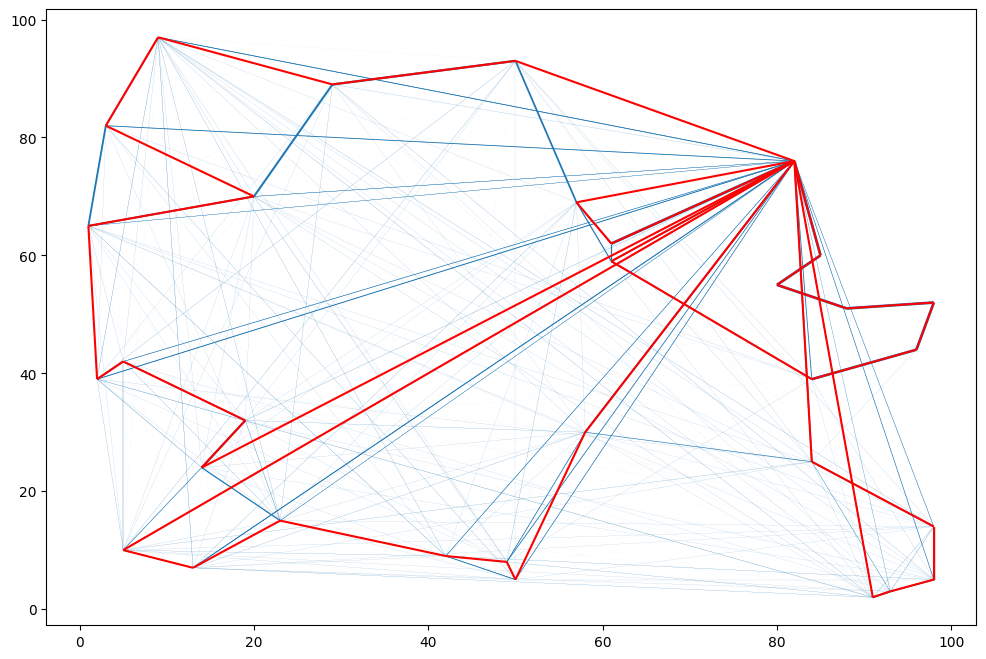

In [15]:
show_results()

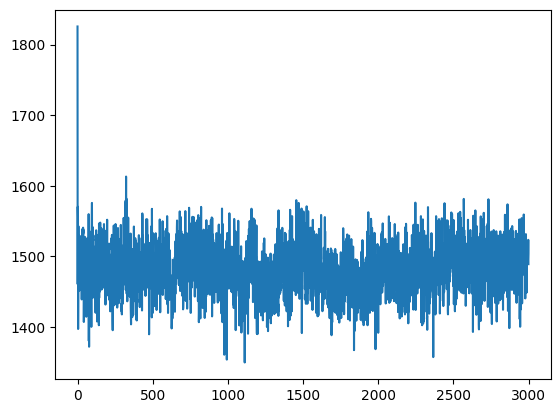

In [16]:
plt.plot(all_mins)

# XML 72

In [18]:
file_path = 'data/data_72.xml'
parse_xml(file_path, nodes, nodes_id_to_index, depots, vehicles, requests)
depot_idx = depots[0]
capacity = vehicles[0].capacity

best_solution, pheromones, all_mins = ant_solver(ants=30, max_iterations=2000, rho=0.6)
print(best_solution)

Run: 0, Current min: 890.5214, Current mean: 954.2834, Current max: 1101.9174, Overall best: 890.5214
Run: 20, Current min: 701.8073, Current mean: 776.2537, Current max: 918.0763, Overall best: 683.1672
Run: 40, Current min: 698.6409, Current mean: 774.7539, Current max: 891.8060, Overall best: 677.2872
Run: 60, Current min: 693.1335, Current mean: 784.5949, Current max: 936.8307, Overall best: 677.2872
Run: 80, Current min: 696.2085, Current mean: 754.0300, Current max: 908.5376, Overall best: 677.2872
Run: 100, Current min: 698.4113, Current mean: 740.7616, Current max: 848.8838, Overall best: 677.2872
Run: 120, Current min: 696.6157, Current mean: 784.6145, Current max: 926.5623, Overall best: 677.2872
Run: 140, Current min: 734.1769, Current mean: 800.4566, Current max: 938.6603, Overall best: 677.2872
Run: 160, Current min: 688.0931, Current mean: 783.0829, Current max: 945.2654, Overall best: 677.2872
Run: 180, Current min: 696.3126, Current mean: 789.7845, Current max: 906.3196

Number of cars: 4
Total distance travelled: 270.4973342428335
[[node(id=1, cx=0.0, cy=0.0),
  node(id=21, cx=3.0, cy=6.0),
  node(id=30, cx=3.0, cy=7.0),
  node(id=24, cx=2.0, cy=8.0),
  node(id=27, cx=2.0, cy=9.0),
  node(id=25, cx=1.0, cy=9.0),
  node(id=26, cx=1.0, cy=10.0),
  node(id=31, cx=4.0, cy=8.0),
  node(id=22, cx=5.0, cy=9.0),
  node(id=23, cx=5.0, cy=10.0),
  node(id=29, cx=5.0, cy=12.0),
  node(id=28, cx=6.0, cy=14.0),
  node(id=43, cx=2.0, cy=21.0),
  node(id=45, cx=1.0, cy=21.0),
  node(id=47, cx=1.0, cy=22.0),
  node(id=54, cx=1.0, cy=23.0),
  node(id=44, cx=2.0, cy=22.0),
  node(id=46, cx=-1.0, cy=24.0),
  node(id=53, cx=-5.0, cy=26.0),
  node(id=49, cx=-2.0, cy=21.0),
  node(id=48, cx=-2.0, cy=20.0),
  node(id=71, cx=-5.0, cy=19.0),
  node(id=52, cx=-5.0, cy=18.0),
  node(id=50, cx=-4.0, cy=18.0),
  node(id=51, cx=-4.0, cy=19.0),
  node(id=1, cx=0.0, cy=0.0)],
 [node(id=1, cx=0.0, cy=0.0),
  node(id=32, cx=-6.0, cy=1.0),
  node(id=33, cx=-6.0, cy=2.0),
  node(id=35, 

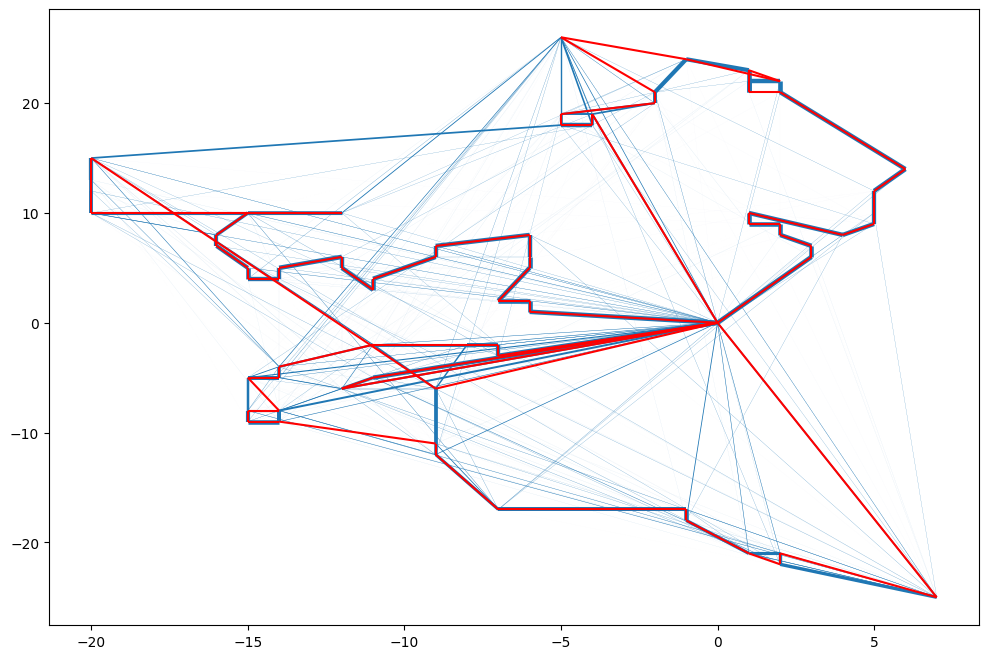

In [19]:
show_results()

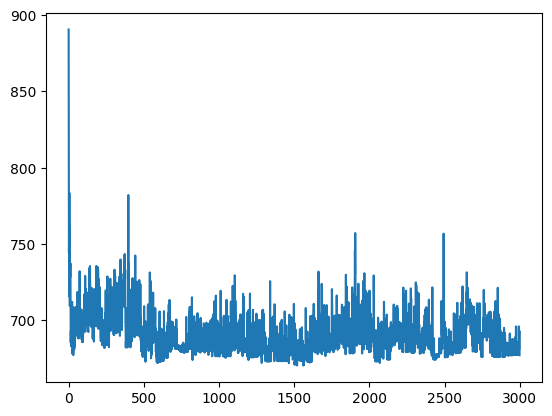

In [20]:
plt.plot(all_mins)

# XML 422

In [9]:
file_path = 'data/data_422.xml'
parse_xml(file_path, nodes, nodes_id_to_index, depots, vehicles, requests)
depot_idx = depots[0]
capacity = vehicles[0].capacity

best_solution, pheromones, all_mins = ant_solver(ants=40, max_iterations=200, rho=0.01)
print(best_solution)

Run: 0, Current min: 7316.1458, Current mean: 7717.8368, Current max: 8105.9499, Overall best: 7316.1458
Run: 10, Current min: 6424.4994, Current mean: 6602.6094, Current max: 6826.9009, Overall best: 6351.4476
Run: 20, Current min: 6320.3462, Current mean: 6562.0660, Current max: 6818.5273, Overall best: 6320.3462
Run: 30, Current min: 6395.1316, Current mean: 6609.4854, Current max: 6799.2387, Overall best: 6227.7966
Run: 40, Current min: 6376.6584, Current mean: 6635.4258, Current max: 6883.6384, Overall best: 6227.7966
Run: 50, Current min: 6486.9502, Current mean: 6686.6068, Current max: 6907.0787, Overall best: 6227.7966
Run: 60, Current min: 6446.5231, Current mean: 6719.0939, Current max: 6911.3930, Overall best: 6227.7966
Run: 70, Current min: 6534.9627, Current mean: 6786.2454, Current max: 7095.2437, Overall best: 6227.7966
Run: 80, Current min: 6563.8693, Current mean: 6782.4289, Current max: 7023.4778, Overall best: 6227.7966
Run: 90, Current min: 6448.3048, Current mean: 

Number of cars: 39
Total distance travelled: 2327.79658293881
[[node(id=421, cx=0.0, cy=0.0),
  node(id=66, cx=3.6084, cy=-6.25),
  node(id=106, cx=2.5259, cy=-6.25),
  node(id=55, cx=2.1651, cy=-6.25),
  node(id=56, cx=1.4434, cy=-7.5),
  node(id=116, cx=1.8042, cy=-9.375),
  node(id=175, cx=3.3829, cy=-9.7656),
  node(id=226, cx=3.9467, cy=-9.7656),
  node(id=186, cx=5.6382, cy=-9.7656),
  node(id=293, cx=8.1049, cy=-10.376),
  node(id=238, cx=8.4573, cy=-9.7656),
  node(id=179, cx=9.0211, cy=-7.8125),
  node(id=421, cx=0.0, cy=0.0)],
 [node(id=421, cx=0.0, cy=0.0),
  node(id=211, cx=-4.2286, cy=12.207),
  node(id=262, cx=-4.9334, cy=12.207),
  node(id=243, cx=-7.0477, cy=12.207),
  node(id=269, cx=-8.1049, cy=10.376),
  node(id=214, cx=-8.4573, cy=9.7656),
  node(id=155, cx=-9.0211, cy=7.8125),
  node(id=156, cx=-11.2764, cy=7.8125),
  node(id=215, cx=-11.2764, cy=9.7656),
  node(id=274, cx=-10.5716, cy=12.207),
  node(id=329, cx=-10.1311, cy=12.97),
  node(id=389, cx=-12.6639, cy=1

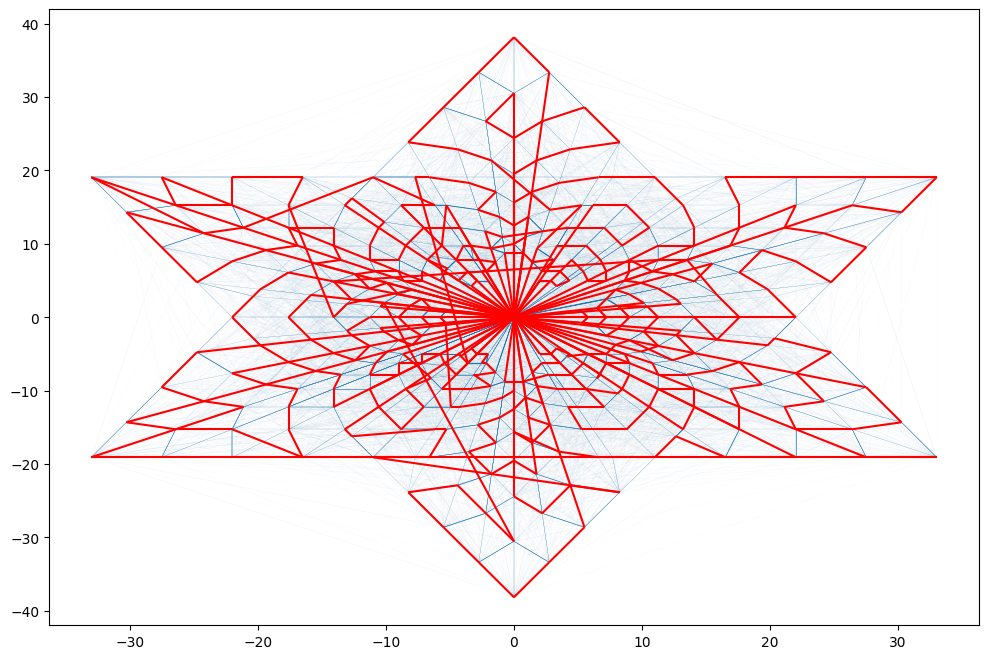

In [10]:
show_results()

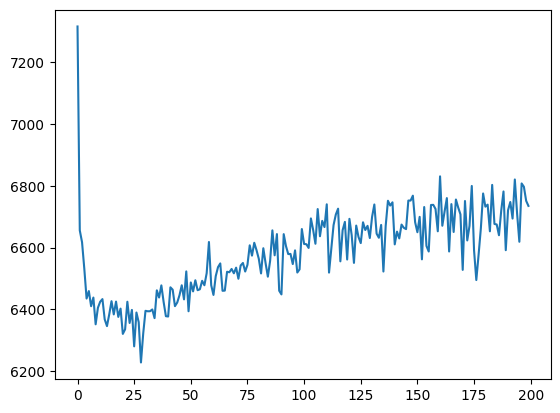

In [11]:
plt.plot(all_mins)